#  Segmentation des Données
##  Objectif de la Présentation
> Cette présentation a pour but de **comparer deux approches majeures de la segmentation de données  appliquées au dataset `apple_quality.json`** :
>
> - Une **segmentation non supervisée**, via l’algorithme **KMeans**
> -L'algorithme HAC

## 🔹 Partie 1 — KMeans : Segmentation





###  Définition et Principe de Fonctionnement
> **KMeans** est un algorithme de *clustering* qui regroupe les données sans connaissance préalable des catégories.
> Il vise à **minimiser la variance intra-cluster** tout en maximisant la distance entre les groupes.

###  Objectif

- Regrouper automatiquement les **pommes selon leurs caractéristiques physiques** (taille, acidité, jutosité, etc.)
- **Sans utiliser l’étiquette de qualité**
- Identifier des **profils naturels de pommes** (ex : sucrées & croquantes, acides & dures...)


###  Cas Pratique sur `apple_quality.json
- Variables utilisées : `Size`, `Weight`, `Sweetness`, `Crunchiness`, `Juiciness`, `Ripeness`, `Acidity`
- Colonne ignorée : `Quality` (notre cible supervisée)

####  Importation


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster


**Chargement des données JSON**

In [ ]:

file_path = '/content/apple_quality.json'
data = pd.read_json(file_path)
print(" Données chargées avec succès")
display(data.head())
X = data.drop(columns=["A_id", "Quality"])

 Données chargées avec succès


,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,0.0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590483,good
1,1.0,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809367,good
2,2.0,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636473,bad
3,3.0,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723217,good
4,4.0,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984036,good


**Affichage des statistiques descriptives**

🔍 Statistiques descriptives :


,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,-0.503015,-0.989547,-0.470479,0.985478,0.512118,0.498277
std,1.928059,1.602507,1.943441,1.402757,1.930286,1.874427
min,-7.151703,-7.149848,-6.894485,-6.055058,-5.961897,-5.864599
25%,-1.816765,-2.011770,-1.738425,0.062764,-0.801286,-0.771677
50%,-0.513703,-0.984736,-0.504758,0.998249,0.534219,0.503445
75%,0.805526,0.030976,0.801922,1.894234,1.835976,1.766212
max,6.406367,5.790714,6.374916,7.619852,7.364403,7.237837


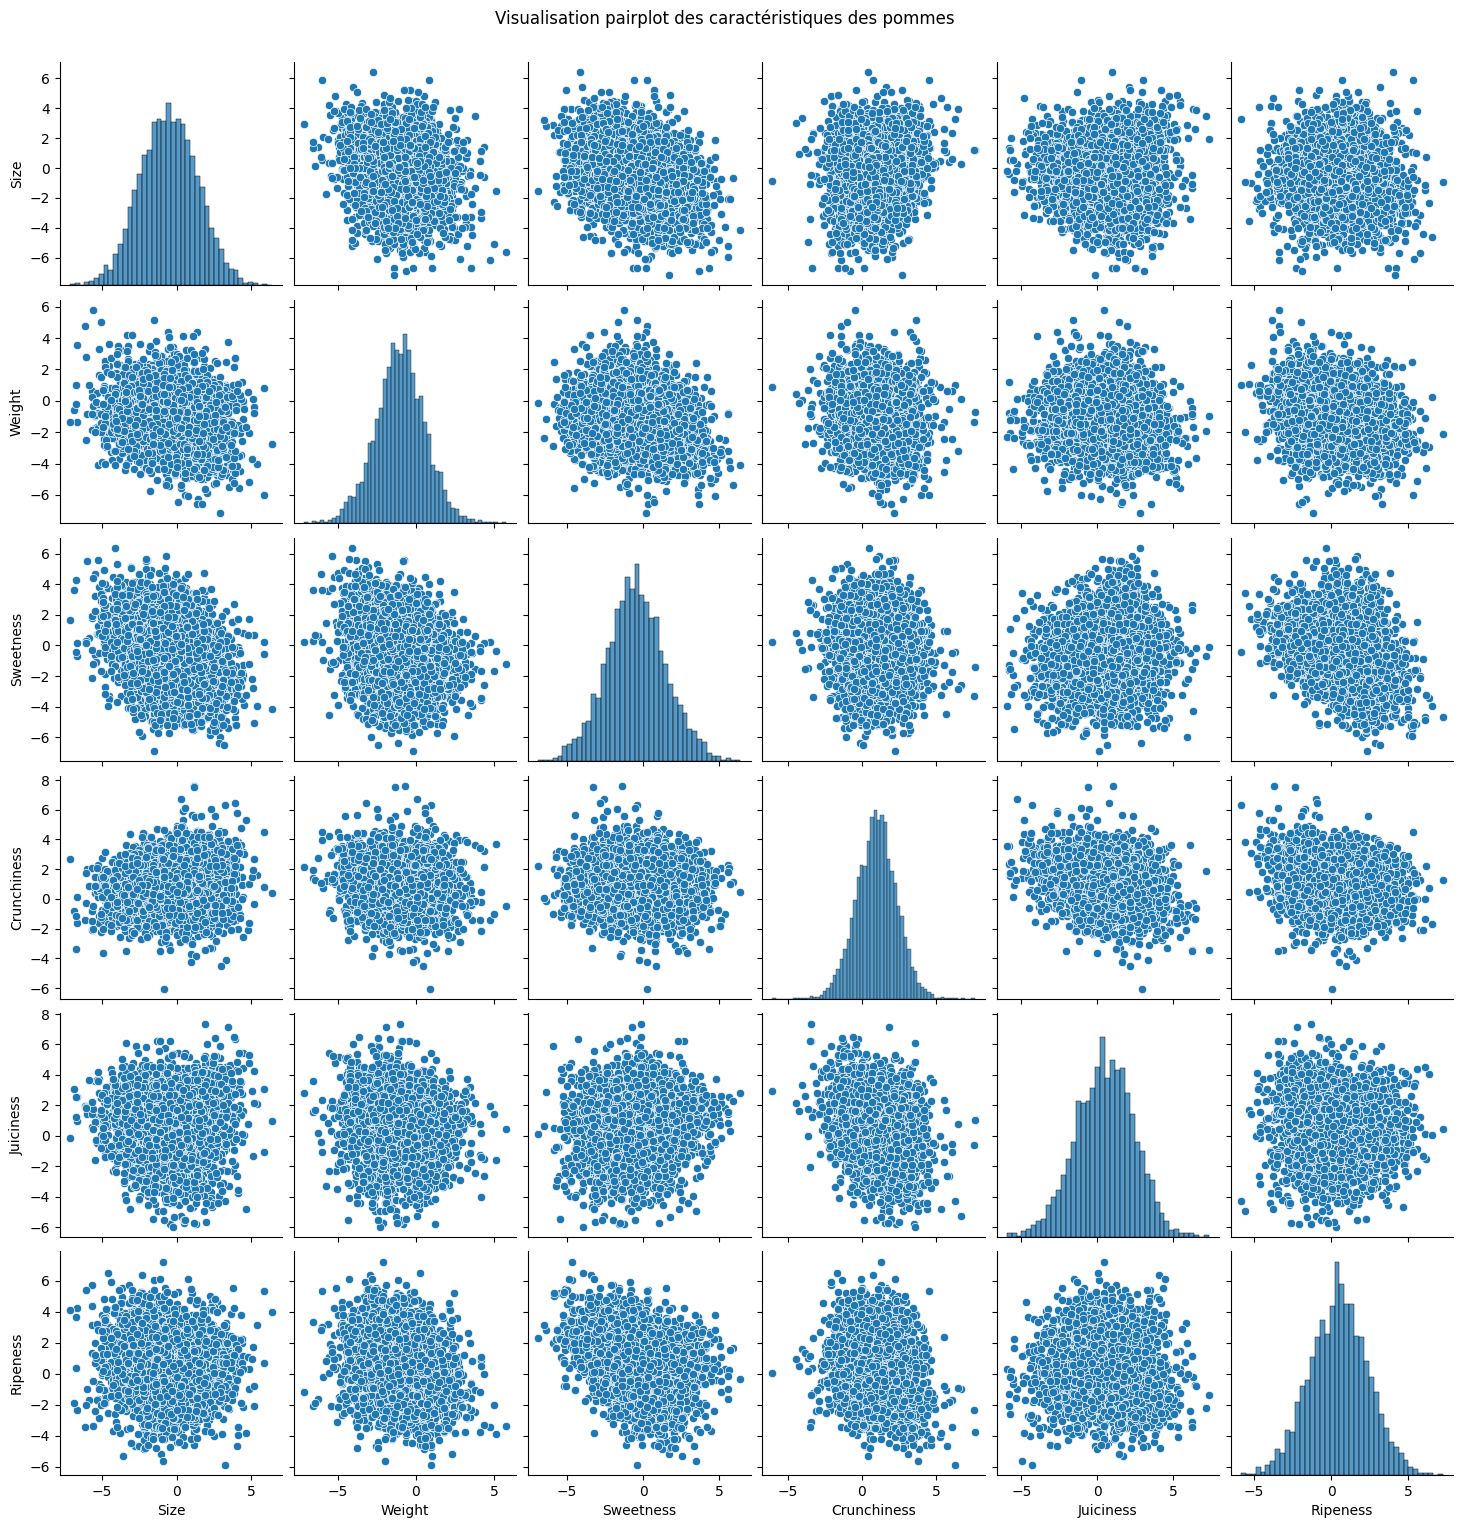

In [ ]:
print("🔍 Statistiques descriptives :")
display(X.describe())
sns.pairplot(X)
plt.suptitle("Visualisation pairplot des caractéristiques des pommes", y=1.02)
plt.show()

 **Nettoyage**

In [ ]:

X_cleaned = X.drop(columns=['A_id', 'Quality'], errors='ignore')
X_cleaned = X_cleaned.apply(pd.to_numeric, errors='coerce')


print("Nombre de NaN par colonne :\n", X_cleaned.isna().sum())


X_cleaned['Acidity'] = X_cleaned['Acidity'].astype(float)

print("NaN après conversion finale :", X_cleaned.isna().sum().sum())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cleaned)


Nombre de NaN par colonne :
 Size           1
Weight         1
Sweetness      1
Crunchiness    1
Juiciness      1
Ripeness       1
Acidity        1
dtype: int64
NaN après conversion finale : 7


**Suppression des lignes avec des NaN**

In [ ]:

X_cleaned = X_cleaned.dropna()
X_scaled = scaler.fit_transform(X_cleaned)
print("Dimensions après suppression des NaN :", X_cleaned.shape)

Dimensions après suppression des NaN : (4000, 7)


**Le graphique ci-dessous montre l’évolution de l’inertie en fonction du nombre de clusters**

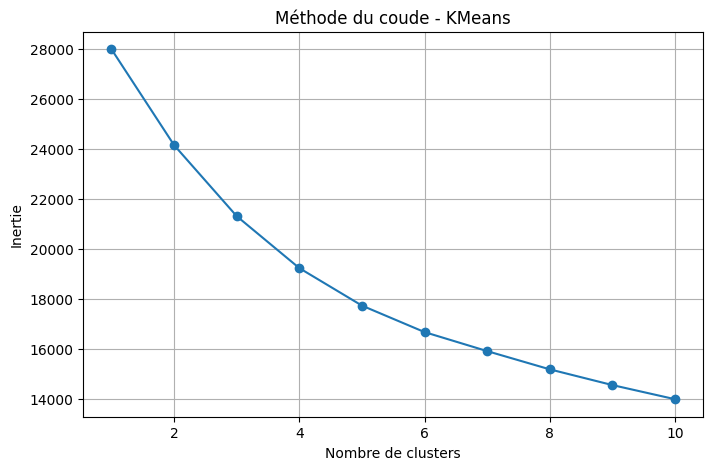

In [ ]:

inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(k_range, inertia, marker='o')
plt.title("Méthode du coude - KMeans")
plt.xlabel("Nombre de clusters")
plt.ylabel("Inertie")
plt.grid(True)
plt.show()


***C’est à K = 5 que la courbe forme un coude bien visible, marquant un équilibre entre simplicité (peu de clusters) et qualité de segmentation (faible inertie). Mais étant donne que notre objectif est de faire une séparation des pommes de bonnes et de mauvaises qualité, on ferra une séparation binaire (K=2)***

**Application du clustering avec K=2**

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)
X_cleaned['Cluster'] = clusters
X_cleaned.head()


,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Cluster
0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590,1
1,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809,1
2,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636,1
3,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723,1
4,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984,1


Chaque observation est assignée à l’un des deux clusters formés en se basant sur la similarité des caractéristiques. Le résultat est enregistré dans une nouvelle colonne Cluster dans notre jeu de données nettoyé.


**Visualisation des clusters avec PCA**

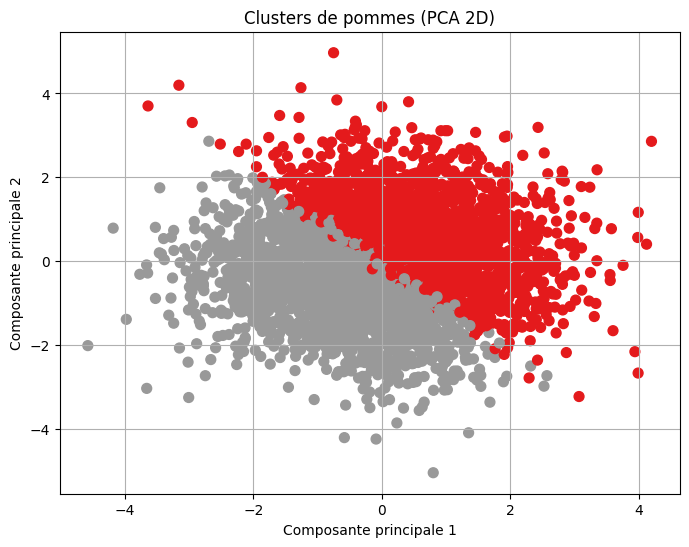

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='Set1', s=50)
plt.title("Clusters de pommes (PCA 2D)")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.grid(True)
plt.show()

Afin de visualiser les clusters formés dans un espace bidimensionnel, nous avons appliqué une réduction de dimension par ACP (Analyse en Composantes Principales - PCA).

Les deux premières composantes principales permettent de représenter graphiquement les observations selon leur appartenance aux clusters formés par K-Means.
Chaque point représente une pomme, colorée selon son cluster.

Cette visualisation permet d’avoir un aperçu clair de la séparation (ou du chevauchement) entre les groupes.

**Visualisation 3D des clusters avec PCA**

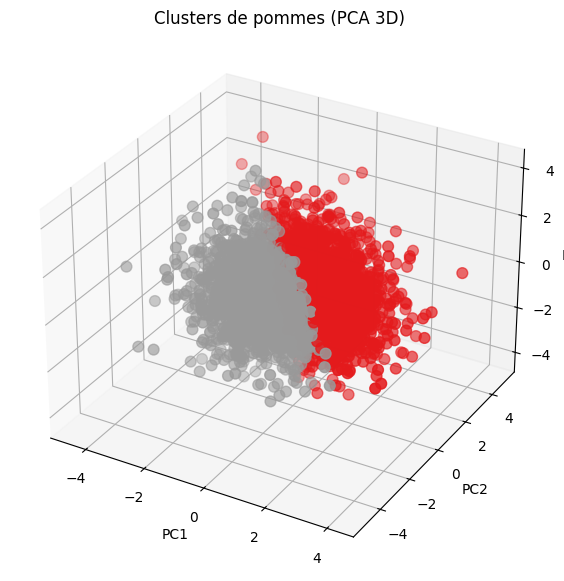

In [ ]:
from mpl_toolkits.mplot3d import Axes3D


pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=clusters, cmap='Set1', s=60)
ax.set_title("Clusters de pommes (PCA 3D)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()


In [ ]:
cluster_profiles = X_cleaned.groupby("Cluster").mean(numeric_only=True)
cluster_profiles

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity
Cluster,,,,,,,
0,-0.020712,-0.991799,-1.538373,1.264791,-0.481304,1.163472,-0.603939
1,-1.017719,-0.987143,0.669161,0.687400,1.572281,-0.211608,0.803433


**Cluster 0** : pommes plus croquantes et plus mûres, mais moins sucrées et moins juteuses.

**Cluster 1** : pommes plus sucrées, juteuses et acides, mais moins croquantes et moins mûres.

Ces profils montrent que les clusters se distinguent par des caractéristiques claires et interprétables, ce qui permet d’orienter l’usage ou le tri des pommes selon les préférences du marché ou du consommateur (par exemple, pommes à croquer vs pommes à jus).

**Visualisation des profils des clusters (Radar Chart)**

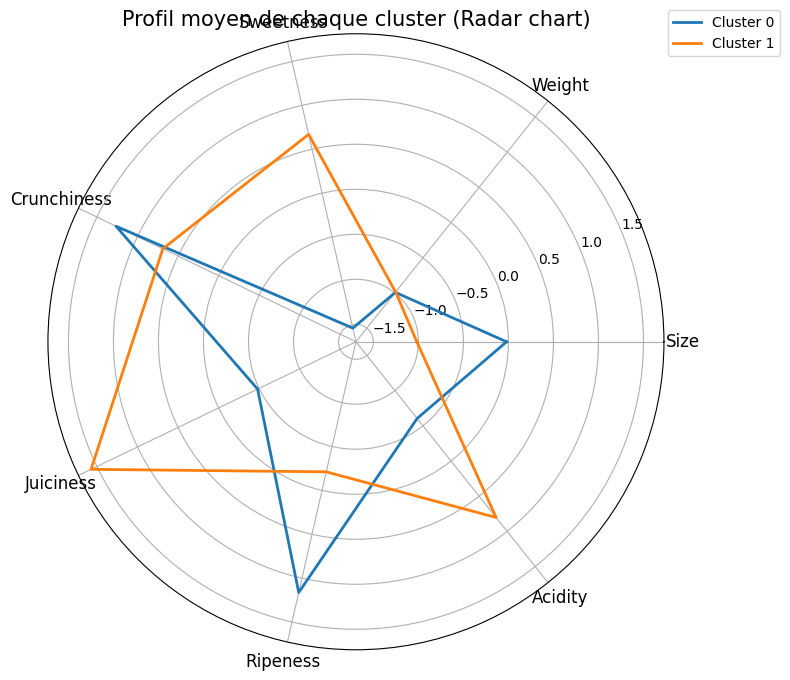

In [ ]:

features = cluster_profiles.columns
num_clusters = cluster_profiles.shape[0]

angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False).tolist()
angles += angles[:1]

plt.figure(figsize=(10, 8))
for i in range(num_clusters):
    values = cluster_profiles.iloc[i].tolist()
    values += values[:1]
    plt.polar(angles, values, label=f"Cluster {i}", linewidth=2)

plt.xticks(angles[:-1], features, fontsize=12)
plt.title("Profil moyen de chaque cluster (Radar chart)", size=15)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.05))
plt.show()


**Le radar chart** permet de visualiser, en un seul coup d’œil, les différences globales entre les clusters selon l’ensemble des variables normalisées.

Cluster 0 se distingue par une forte croquantise et une maturité élevée, mais une faible sucrosité et jutosité.

Cluster 1 présente un profil plus sucré, plus juteux et plus acide, mais moins croquant.

Ce type de représentation est particulièrement utile pour :

comparer visuellement les groupes sur plusieurs dimensions à la fois,

faciliter la prise de décision dans le ciblage de produits ou de marchés (ex. : jus vs consommation directe).

# ajouter la colonne 'Quality'

In [ ]:

data_cleaned = data.loc[X_cleaned.index]
X_cleaned['Quality'] = data_cleaned['Quality'].values

In [ ]:
X_cleaned.head()

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Cluster,Quality
0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590,1,good
1,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809,1,good
2,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636,1,bad
3,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723,1,good
4,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984,1,good


Afin de comparer les résultats des clusters obtenus avec la véritable qualité des pommes, il est nécessaire de transformer cette variable catégorielle (Quality) en valeurs numériques.

#Matrice de confusion

In [ ]:
le = LabelEncoder()
X_cleaned['Quality_encoded'] = le.fit_transform(X_cleaned['Quality'])

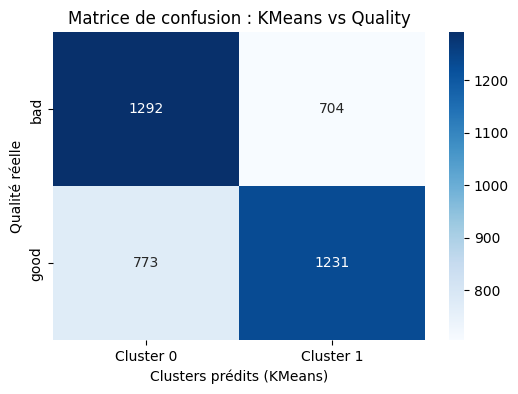

In [ ]:

cm_kmeans = confusion_matrix(X_cleaned['Quality_encoded'], X_cleaned['Cluster'])
plt.figure(figsize=(6, 4))
sns.heatmap(cm_kmeans, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Cluster 0', 'Cluster 1'],
            yticklabels=le.classes_)
plt.title("Matrice de confusion : KMeans vs Quality")
plt.xlabel("Clusters prédits (KMeans)")
plt.ylabel("Qualité réelle")
plt.show()


# Interprétation
Le modèle KMeans a réussi à capturer une certaine structure dans les données : il a correctement identifié une grande partie des bad et good.

Mais la confusion n’est pas négligeable : près de 36 % des "bad" sont classés comme "good", et environ 39 % des "good" sont classés comme "bad".

In [ ]:
accuracy = (1292 + 1231) / (1292 + 704 + 773 + 1231)
print(accuracy)

0.63075


le clustering KMeans atteint environ 63 % de correspondance avec les vraies étiquettes.

#Partie 2 : H A C

L'algorithme HAC (Hierarchical Agglomerative Clustering) est une méthode de regroupement hiérarchique ascendante, qui commence par considérer chaque observation comme un cluster individuel, puis les regroupe progressivement en fonction de leur similarité jusqu’à obtenir le nombre souhaité de clusters.

Dans ce projet, nous avons appliqué HAC avec deux clusters (comme pour K-Means) afin de comparer les résultats avec la variable cible réelle, à savoir la qualité des pommes.

Étapes réalisées :
Nous avons utilisé la distance euclidienne pour mesurer la similarité entre les données.

Le critère de liaison choisi est "ward", qui minimise la variance intra-cluster lors de chaque fusion.

Après l'application de HAC, les clusters obtenus ont été ajoutés à notre DataFrame X_scaled_df dans la colonne Cluster_Hierarchique.

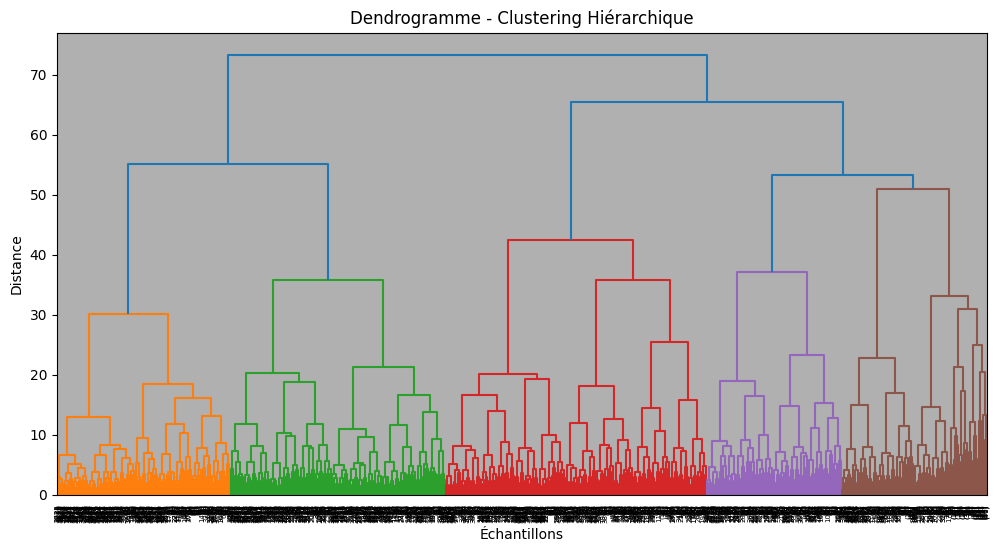

In [ ]:
linked = linkage(X_scaled, method='ward')
plt.figure(figsize=(12, 6))
dendrogram(linked, truncate_mode='level', p=10)
plt.title("Dendrogramme - Clustering Hiérarchique")
plt.xlabel("Échantillons")
plt.ylabel("Distance")
plt.grid()
plt.show()

In [ ]:

original_features = data.drop(columns=["A_id", "Quality"]).columns
X_scaled_df = pd.DataFrame(X_scaled, columns=original_features)
cluster_labels = fcluster(linked, t=2, criterion='maxclust')
X_scaled_df['Cluster_Hierarchique'] = cluster_labels # Assign to the DataFrame

X_scaled_df.head()

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Cluster_Hierarchique
0,-1.798424,-0.950373,2.993421,-1.424150,0.690545,-0.089872,-0.269415,2
1,-0.359060,-1.154404,2.127698,0.429746,0.176767,0.197020,-0.378997,2
2,0.109445,-0.225759,-0.652507,-0.946892,1.205422,-0.286156,1.206044,2
3,-0.079977,-0.800146,0.923916,-0.772399,1.619575,-2.087320,0.338315,1
4,0.968573,-0.191640,0.044164,-1.096894,1.305025,-0.961548,0.201472,2


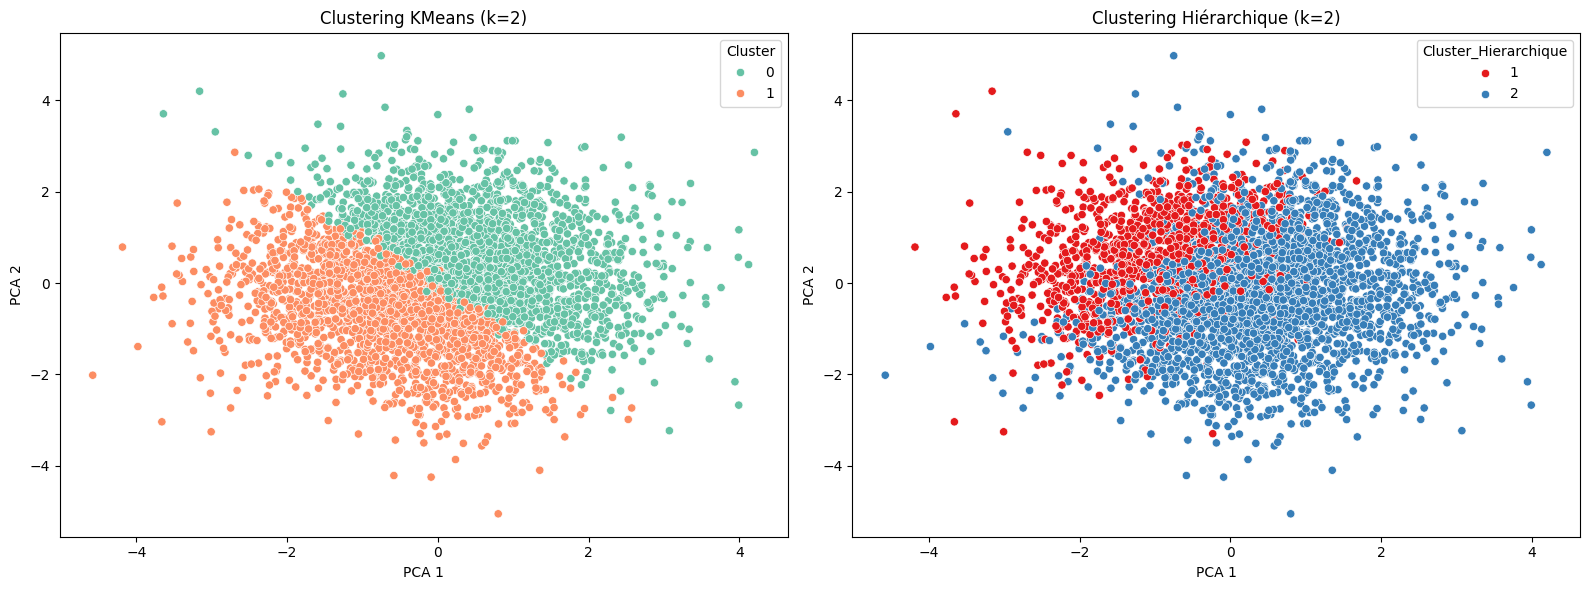

In [ ]:

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Cluster KMeans
sns.scatterplot(ax=axs[0], x=X_pca[:, 0], y=X_pca[:, 1],
                hue=X_cleaned['Cluster'], palette='Set2')
axs[0].set_title("Clustering KMeans (k=2)")
axs[0].set_xlabel("PCA 1")
axs[0].set_ylabel("PCA 2")

# Cluster Hiérarchique
sns.scatterplot(ax=axs[1], x=X_pca[:, 0], y=X_pca[:, 1],
                hue=X_scaled_df['Cluster_Hierarchique'], palette='Set1')
axs[1].set_title("Clustering Hiérarchique (k=2)")
axs[1].set_xlabel("PCA 1")
axs[1].set_ylabel("PCA 2")

plt.tight_layout()
plt.show()


In [ ]:
X_cleaned['Cluster_Hierarchique'] = X_scaled_df['Cluster_Hierarchique']

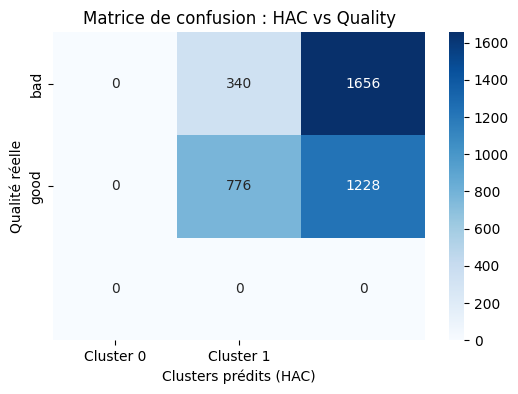

In [ ]:

cm_kmeans = confusion_matrix(X_cleaned['Quality_encoded'], X_cleaned['Cluster_Hierarchique'])
plt.figure(figsize=(6, 4))
sns.heatmap(cm_kmeans, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Cluster 0', 'Cluster 1'],
            yticklabels=le.classes_)
plt.title("Matrice de confusion : HAC vs Quality")
plt.xlabel("Clusters prédits (HAC)")
plt.ylabel("Qualité réelle")
plt.show()


In [ ]:
accuracy = (340 + 1228) / (1656 + 340 + 776 + 1228)
print(accuracy)

0.392


#Conclusion
Résultats de Performance
K-Means (63% de précision) :
A montré une meilleure adéquation avec nos données, séparant plus efficacement les bonnes pommes des mauvaises. Cela suggère que nos données ont des groupes bien délimités, ce que K-Means gère bien grâce à sa nature basée sur les centroïdes.

Clustering Hiérarchique (HAC) (39% de précision) :
A donné des résultats moins performants.

